# ARIMA model predicting future stock price

### 0. Load Dependencies

In [137]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.types import Integer, Text, String, Float, Date

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima.utils import nsdiffs
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from scipy.signal import find_peaks

In [138]:
def plot_line(x, y, x_label = None, y_label = None, title = None):
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, ls = '-')
    plt.xlabel(x_label, fontsize = 13)
    plt.ylabel(y_label, fontsize = 13)
    plt.title(title, fontsize = 15)
    plt.show()

In [139]:
def abs2(x):
    return x.real**2 + x.imag**2

In [140]:
def next_month_end(time):
    if time.month == 12:
        y = time.year + 1
        m = 2
        return datetime(year = time.year + 1, month = 2, day = 1)- timedelta(days = 1)
    elif time.month == 11:
        y = time.year + 1
        m = 1
        return datetime(year = time.year + 1, month = 1, day = 1)- timedelta(days = 1)
    else:
        y = time.year
        m = time.month + 2
    return datetime(year = y, month = m, day = 1) - timedelta(days = 1)

### 1. Load SQLite database

In [141]:
#################################################
# 1. Database Setup
#################################################
engine = create_engine("sqlite:///../data/CompanyData.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save reference to the table
MasterData = Base.classes.MasterData
QuintileMonthlyData = Base.classes.QuintileMonthlyData
QuintileAvgData = Base.classes.QuintileAvgData

In [142]:
#################################################
# 2. Tables
#################################################
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the database
print("Table Names: ")
print(inspector.get_table_names())

Table Names: 
['CurrentData', 'FinData2', 'Future6Mon', 'MasterData', 'MasterData_ML', 'PiecewiseARIMA', 'PriceData2', 'QuintileAvgData', 'QuintileMonthlyData', 'findata', 'monte_carlo', 'pricedata']


In [143]:
#################################################
# 3. Columns and DataType
#################################################
# Using the inspector to print the column names within the 'dow' table and its types
columns = inspector.get_columns('MasterData')
# Column names and DataType
df = pd.DataFrame({"name": [col['name'] for col in columns],
                  "type": [col['type'] for col in columns]})

In [144]:
df.head()

,name,type
0,monthend_date,DATE
1,ticker,VARCHAR(8)
2,price,FLOAT
3,wealth_index,FLOAT
4,end_wealth_index,FLOAT


### 2. Extract price from Individual STOCK

In [145]:
#################################################
# 1. choose stock & query
#################################################
ticker = 'AMZN'#tickers[54]
session = Session(engine)
results = session.query(MasterData).filter(MasterData.ticker == ticker).all()

In [146]:
date = [res.monthend_date for res in results]
wealth_ind = [res.wealth_index for res in results]
end_wealth_ind = [res.end_wealth_index for res in results]
total_return = [res.total_return for res in results]

df = pd.DataFrame({'date': date, 
                   'wealth_ind': wealth_ind, 
                  })
df.head()

,date,wealth_ind
0,2014-11-30,338.64
1,2014-12-31,310.35
2,2015-01-31,354.53
3,2015-02-28,380.16
4,2015-03-31,372.10


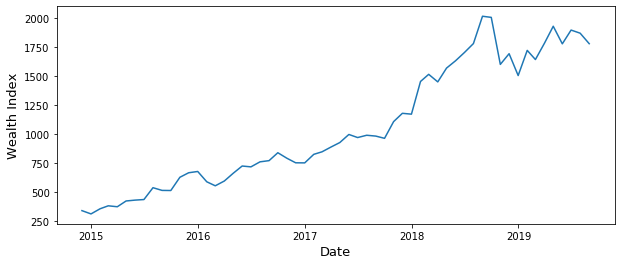

In [147]:
#################################################
# 2. plot raw data
#################################################
plot_line(df.date, df.wealth_ind, 'Date','Wealth Index', None)

## 3. Auto ARIMA -- SARIMA

seasonality: 12


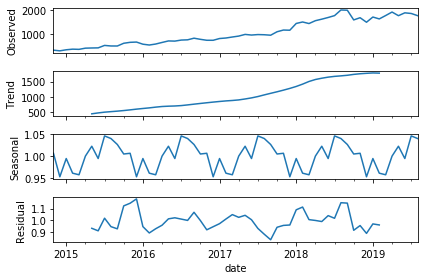

In [12]:
#################################################
# 1. find seasonality
#################################################

data = df.copy()
data = data.set_index('date')
data.index = pd.to_datetime(data.index)

result = seasonal_decompose(data, model='multiplicative')

# find periodicity in seasonal
seasonal = result.seasonal['wealth_ind']
fft = np.fft.rfft(seasonal, norm="ortho")
selfconvol=np.fft.irfft(abs2(fft), norm="ortho")
x, y = find_peaks(selfconvol, distance=6) 

season = 1 if x.size == 0 else x[1]
seasonal = False if x.size == 0 else True

print(f'seasonality: {season}')

# plot seasonal decomposition
result.plot()
plt.show()

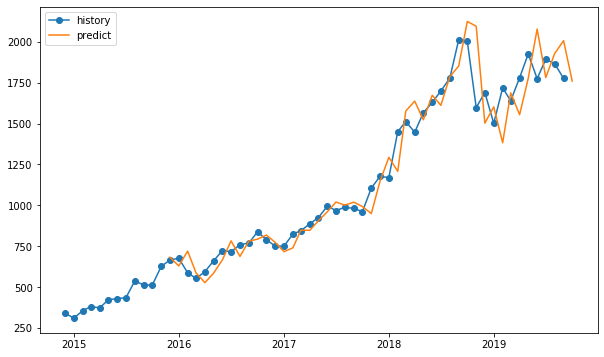

In [13]:
#################################################
# 2. fit Auto_ARIMA with season -- dynamically ARIMA(p, d, q)(P, 12, Q)
#################################################

period = 12 if season ==1 else season
history = [data[i: i+period] for i in range(len(data) - period + 1)]

predict = []

for h in history:
    D = 0 if season == 1 else nsdiffs(h, m=12, max_D=season, test='ch') # determine seasonal D
    pre_dict = {}
    stepwise_model = pm.auto_arima(h, start_p=1, start_q=1,
                                test='adf',
                        max_p=3, max_q=3, m=season,
                        start_P=0, seasonal=seasonal,
                        d=None, D=D, trace=False,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    print("ARIMA order: ", stepwise_model.order,stepwise_model.seasonal_order, end = '\r')
    model_fit = stepwise_model.fit(h)
    p = model_fit.predict(n_periods = 1)
    pre_dict['predict_time'] = next_month_end(h.index[-1])
    pre_dict['price'] = p[0]
    predict.append(pre_dict)

#################################################
# 3. plot comparison with historic data
#################################################
predict_time = list(data[period::].index) + list(data.tail(1).index + timedelta(days = 30))
predict_price = [x['price'] for x in predict]
plt.figure(figsize = (10,6))
plt.plot(data,marker = 'o', label = 'history')
plt.plot(predict_time, predict_price, label = 'predict')
plt.legend(loc = 'best')
plt.show()

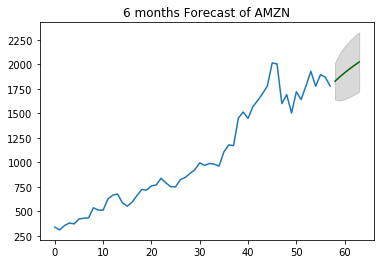

In [14]:
#################################################
# 4. Forcast future 6 months
#################################################
n_periods = 6

D = nsdiffs(h, m=season, max_D=12, test='ch') # determine seasonal D
stepwise_model = pm.auto_arima(data, start_p=1, start_q=1,
                               test='adf',
                               max_p=3, max_q=3, m=season,
                               start_P=0, seasonal=True,
                               d=None, D=D, trace=False,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
print("ARIMA order: ", stepwise_model.order,stepwise_model.seasonal_order, end = '\r')
model_fit = stepwise_model.fit(data)

fc, confint = stepwise_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.wealth_ind), len(df.wealth_ind)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.wealth_ind)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title(f"{n_periods} months Forecast of {ticker}")
plt.show()

Fit ARIMA: order=(1, 1, 1); AIC=691.654, BIC=699.826, Fit time=0.056 seconds
Fit ARIMA: order=(0, 1, 0); AIC=692.345, BIC=696.431, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=691.772, BIC=697.901, Fit time=0.024 seconds
Fit ARIMA: order=(0, 1, 1); AIC=691.710, BIC=697.840, Fit time=0.022 seconds
Fit ARIMA: order=(2, 1, 1); AIC=692.783, BIC=702.998, Fit time=0.056 seconds
Fit ARIMA: order=(1, 1, 2); AIC=692.904, BIC=703.120, Fit time=0.068 seconds
Fit ARIMA: order=(2, 1, 2); AIC=695.654, BIC=707.912, Fit time=0.155 seconds
Total fit time: 0.388 seconds

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   57
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -341.827
Method:                       css-mle   S.D. of innovations             95.565
Date:                Wed, 30 Oct 2019   AIC                            691.654
Time:                        10:32:

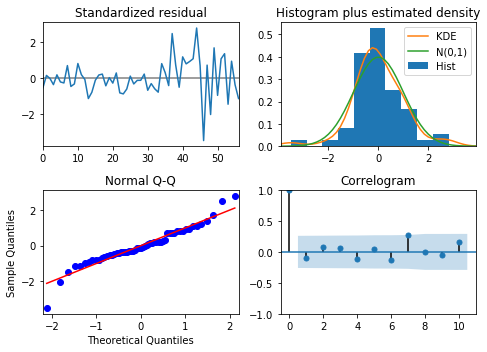

In [15]:
## AUTO ARIMA
model = pm.auto_arima(df.wealth_ind, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=season,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # Include Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print()
print(model.summary())

model.plot_diagnostics(figsize=(7,5))
plt.tight_layout()
plt.show()

# 3.1 Build Database

In [16]:
# get all tickers
session = Session(engine)
result = session.query(MasterData.ticker).all()
tickers = list(np.unique([x[0] for x in result]))

In [17]:
# create an empty DataFrame to store result
ARIMA = pd.DataFrame(columns = ["ticker",'future_6_mon', 'piecewise_arima'])
ARIMA

,ticker,future_6_mon,piecewise_arima


In [ ]:
for i in range(0,len(tickers)):
    ticker = tickers[i]
    # 1. get price
    #################################################
    results = session.query(MasterData).filter(MasterData.ticker == ticker).all()
    date = [res.monthend_date for res in results]
    
    wealth_ind = [res.wealth_index for res in results]
    
    data = pd.DataFrame({'date': date, 
                   'wealth_ind': wealth_ind, 
                  })
    
    # 2. seasonality
    #################################################
    if len(date) <= 12:
        continue
    else:
        data = data.set_index('date')
        data.index = pd.to_datetime(data.index)
        result = seasonal_decompose(data, model='multiplicative')

        ### 2.1 find periodicity in seasonal
        seasonal = result.seasonal['wealth_ind']
        fft = np.fft.rfft(seasonal, norm="ortho")
        selfconvol=np.fft.irfft(abs2(fft), norm="ortho")
        x, y = find_peaks(selfconvol, distance=6) 
        season = 1 if x.size == 0 else x[1]
        seasonal = False if x.size == 0 else True
    
    # 3. fit Auto_ARIMA with season -- dynamically ARIMA(p, d, q)(P, 12, Q)
    #################################################
        predict = []
        period = 12 if season ==1 else season;
        history = [data[i: i+period] for i in range(len(data) - period + 1)]

        for h in history:
            D = 0 if season == 1 else nsdiffs(h, m=12, max_D=season, test='ch') # determine seasonal D
            pre_dict = {}
            stepwise_model = pm.auto_arima(h, start_p=1, start_q=1,
                                        test='adf',
                                max_p=3, max_q=3, m=season,
                                start_P=0, seasonal=seasonal,
                                d=None, D=D, trace=False,
                                error_action='ignore',  
                                suppress_warnings=True, 
                                stepwise=True)
            print(f"Progress: {(tickers.index(ticker) + 1)} / {len(tickers)},", ticker,
                  "step ARIMA order: ", 
                  stepwise_model.order,stepwise_model.seasonal_order,"                              ", end = '\r')
            model_fit = stepwise_model.fit(h)
            p = model_fit.predict(n_periods = 1)
            pre_dict['predict_time'] = next_month_end(h.index[-1])
            pre_dict['price'] = p[0]
            predict.append(pre_dict)
    

    # 4. Forcast future 6 months
    #################################################
        n_periods = 6

        D = 0 if season == 1 else nsdiffs(h, m=12, max_D=season, test='ch') # determine seasonal D
        stepwise_model = pm.auto_arima(data, start_p=1, start_q=1,
                                    test='adf',
                                    max_p=3, max_q=3, m=season,
                                    start_P=0, seasonal=seasonal,
                                    d=None, D=D, trace=False,
                                    error_action='ignore',  
                                    suppress_warnings=True, 
                                    stepwise=True)
        print(f"Progress: {(tickers.index(ticker) + 1)} / {len(tickers)},", 
              "predict ARIMA order: ", 
              stepwise_model.order,stepwise_model.seasonal_order, "                                  ", end = '\r')
        model_fit = stepwise_model.fit(data)

        fc, confint = stepwise_model.predict(n_periods=n_periods, return_conf_int=True)

        future_6_mon = []
        latest_time_stamp = data.index[-1]
        for i in range(len(fc)):
            pre_dict = {}
            latest_time_stamp = next_month_end(latest_time_stamp)
            pre_dict['predict_time'] = datetime.date(latest_time_stamp).isoformat()
            pre_dict['price'] = fc[i]
            pre_dict['conf_int_lo'] = confint[i, 0]
            pre_dict['conf_int_hi'] = confint[i, 1]
            future_6_mon.append(pre_dict)
    
    # 5. Create local Dataframe and store to ARIMA (df)
    #################################################
        test = pd.DataFrame({
        "ticker": ticker,
        "seasonality": season,
        "future_6_mon":[future_6_mon],
        "piecewise_arima": [predict],
        "future_6_mon_model_order": f"{stepwise_model.order} {stepwise_model.seasonal_order}"
        })

        ARIMA = ARIMA.append(test, ignore_index=True)
    
print("Done!                                                                                       ")

In [25]:
ARIMA_TABLE = ARIMA.copy()
ARIMA_TABLE.head()

,future_6_mon,future_6_mon_model_order,piecewise_arima,seasonality,ticker
0,"[{'predict_time': '2019-09-30', 'price': 71.32...","(1, 1, 0) (0, 0, 0, 12)","[{'predict_time': 2015-12-31 00:00:00, 'price'...",12.0,A
1,"[{'predict_time': '2019-09-30', 'price': 26.90...","(1, 1, 0) (0, 0, 0, 24)","[{'predict_time': 2016-11-30 00:00:00, 'price'...",24.0,AAL
2,"[{'predict_time': '2019-09-30', 'price': 137.1...","(0, 2, 1) (0, 0, 0, 12)","[{'predict_time': 2015-11-30 00:00:00, 'price'...",12.0,AAP
3,"[{'predict_time': '2019-09-30', 'price': 210.4...","(0, 1, 0) (0, 0, 0, 12)","[{'predict_time': 2015-11-30 00:00:00, 'price'...",12.0,AAPL
4,"[{'predict_time': '2019-09-30', 'price': 65.27...","(0, 2, 1) (0, 0, 0, 12)","[{'predict_time': 2015-11-30 00:00:00, 'price'...",12.0,ABBV


## 3.2 Restructure in DataFrames, prepare for storage in SQLite Database

### 3.2.1 Future 6 month prediction

In [93]:
# 1. create an empty DataFrame
future_6_mon_df = pd.DataFrame(columns = ["ticker",'seasonality',
                                          'predict_time', 'predict_price',
                                          'predict_confin_lo','predict_confin_hi',
                                          'future_6_mon_model_order'])
# 2. Loop through ARIMA_TABLE, and store data in df
for i in range(0,len(ARIMA_TABLE)):
    ticker = ARIMA_TABLE.iloc[i].ticker

    # Future 6 month
    seasonality = ARIMA_TABLE.iloc[i].seasonality
    model_order = ARIMA_TABLE.iloc[i].future_6_mon_model_order
    future_6_mon = ARIMA_TABLE.iloc[i].future_6_mon
    predict_time = [x["predict_time"] for x in future_6_mon]
    predict_price = [x["price"] for x in future_6_mon]
    predict_confin_lo = [x["conf_int_lo"] for x in future_6_mon]
    predict_confin_hi = [x["conf_int_hi"] for x in future_6_mon]

    temp = pd.DataFrame({'ticker': [ticker] * len(predict_time),
                         'seasonality': seasonality,
                         'predict_time': predict_time,
                         'predict_price':predict_price,
                         'predict_confin_lo': predict_confin_lo,
                         'predict_confin_hi': predict_confin_hi,
                         'future_6_mon_model_order': [model_order] * len(predict_time)
                        })
    future_6_mon_df = future_6_mon_df.append(temp, ignore_index=True)
    print(f"{i}/{len(ARIMA_TABLE)}",end = "\r")
future_6_mon_df.seasonality = future_6_mon_df.seasonality.astype('int64') 
print("Done!     ")

Done!     


In [117]:
future_6_mon_df.tail()

,ticker,seasonality,predict_time,predict_price,predict_confin_lo,predict_confin_hi,future_6_mon_model_order
2929,ZTS,12,2019-10-31,128.262975,118.657478,137.868473,"(0, 1, 0) (0, 0, 1, 12)"
2930,ZTS,12,2019-11-30,129.757783,117.993499,141.522067,"(0, 1, 0) (0, 0, 1, 12)"
2931,ZTS,12,2019-12-31,128.193374,114.609174,141.777574,"(0, 1, 0) (0, 0, 1, 12)"
2932,ZTS,12,2020-01-31,129.138717,113.951137,144.326297,"(0, 1, 0) (0, 0, 1, 12)"
2933,ZTS,12,2020-02-29,132.468758,115.831610,149.105906,"(0, 1, 0) (0, 0, 1, 12)"


### 3.2.2 Piecewise ARIMA prediction

In [105]:
# 1. create an empty DataFrame
piecewise_arima_df = pd.DataFrame(columns = ["ticker",'predict_time', 'predict_price'])

# 2. Loop through ARIMA_TABLE, and store data in df
for i in range(0,len(ARIMA_TABLE)):
    ticker = ARIMA_TABLE.iloc[i].ticker
    
    # piecewise ARIMA
    piecewise_arima = ARIMA_TABLE.iloc[i].piecewise_arima
    predict_time_piecewise_arima = [x['predict_time'].strftime("%Y-%m-%d") for x in piecewise_arima]
    predict_price_piecewise_arima = [x['price'] for x in piecewise_arima]

    temp = pd.DataFrame({'ticker': [ticker] * len(predict_time_piecewise_arima),
                                     'predict_time': predict_time_piecewise_arima,
                                     'predict_price':predict_price_piecewise_arima
                                    })
    piecewise_arima_df = piecewise_arima_df.append(temp)
    print(f"{i}/{len(ARIMA_TABLE)}",end = "\r")
print("Done!     ")

Done!     


In [106]:
piecewise_arima_df.head()

,ticker,predict_time,predict_price
0,A,2015-12-31,41.574394
1,A,2016-01-31,40.948351
2,A,2016-02-29,36.231586
3,A,2016-03-31,35.926956
4,A,2016-04-30,39.386925


## 3.3 Store in SQLite Database

In [130]:
create_Future6Mon_sql = 'CREATE TABLE "Future6Mon" (' + \
    'ticker VARCHAR(8), ' + \
    'seasonality INT, ' + \
    'predict_time DATE, ' + \
    'predict_price FLOAT, ' + \
    'predict_confin_lo FLOAT, ' + \
    'predict_confin_hi FLOAT, ' + \
    'future_6_mon_model_order VARCHAR(30), ' + \
    'PRIMARY KEY (predict_time, ticker));'

In [131]:
create_PiecewiseARIMA_sql = 'CREATE TABLE "PiecewiseARIMA" (' + \
    'ticker VARCHAR(8), ' + \
    'predict_time DATE, ' + \
    'predict_price FLOAT, ' + \
    'PRIMARY KEY (predict_time, ticker));'

In [133]:
#To write this dataframe to an SQL table with any keys, do the following
# Use the "df.to_sql" to write the dataframe to an SQL table with a temporary name

# Delete the Temp table if it exists
# sql_stmt = "DROP TABLE Temp"
# engine.execute(sql_stmt)

# Now, write the dataframe to the SQL table
future_6_mon_df.to_sql('Temp', con=engine, if_exists='replace', index=False)

# Drop any existing "Future6Mon" table, the one that will contain the data and index
sql_stmt = "DROP TABLE Future6Mon"
engine.execute(sql_stmt)

# Create the table.  It will be empty
engine.execute(create_Future6Mon_sql)

# Now copy the data from the Temp table into the New table
sql_stmt = "INSERT INTO Future6Mon SELECT * FROM Temp"
engine.execute(sql_stmt)

# Delete the Temp table
sql_stmt = "DROP TABLE Temp"
engine.execute(sql_stmt)

In [135]:
# Now, write the dataframe to the SQL table
piecewise_arima_df.to_sql('Temp', con=engine, if_exists='replace', index=False)

# Drop any existing "Future6Mon" table, the one that will contain the data and index
sql_stmt = "DROP TABLE PiecewiseARIMA"
engine.execute(sql_stmt)

# Create the table.  It will be empty
engine.execute(create_PiecewiseARIMA_sql)

# Now copy the data from the Temp table into the New table
sql_stmt = "INSERT INTO PiecewiseARIMA SELECT * FROM Temp"
engine.execute(sql_stmt)

# Delete the Temp table
sql_stmt = "DROP TABLE Temp"
engine.execute(sql_stmt)

## 4. ARIMA individual parameter check

1 1 1


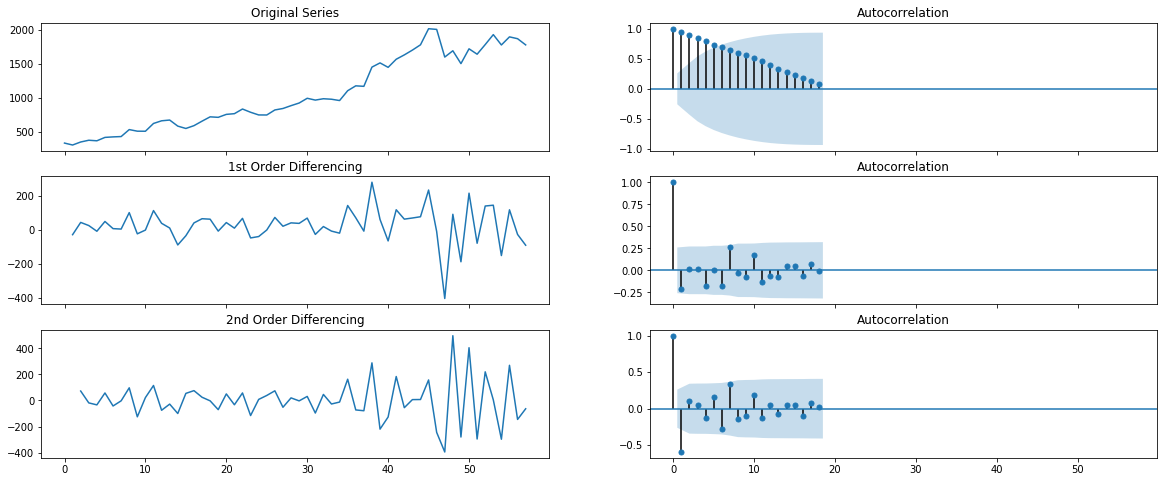

In [148]:
#################################################
# 1. Diff term: d
#################################################
# suggested "d"
y = df.wealth_ind
print(ndiffs(y, test='adf'), ndiffs(y, test='kpss'), ndiffs(y, test='pp')) 

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize = (20, 8))
axes[0, 0].plot(df.wealth_ind); axes[0, 0].set_title('Original Series')
plot_acf(df.wealth_ind, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.wealth_ind.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.wealth_ind.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.wealth_ind.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.wealth_ind.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
#################################################
# 2. AM term: p 
#################################################
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.wealth_ind.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.wealth_ind.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
#################################################
# 3. MA term: q
#################################################
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.wealth_ind.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.wealth_ind.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
#################################################
# 4. build ARIMA model (1, 1, 1)
#################################################
model = ARIMA(df.wealth_ind, (1,1,1))
model_fit = model.fit(disp = 0)
print(model_fit.summary())

In [ ]:
#################################################
# 5. plot residual
#################################################
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()

In [ ]:
model_fit.plot_predict(dynamic=False)
plt.show()

## 3.1 Profitable Stratagy?

In [20]:
test_df = df.copy()
test_df.head()

,date,wealth_ind
0,2014-11-30,338.64
1,2014-12-31,310.35
2,2015-01-31,354.53
3,2015-02-28,380.16
4,2015-03-31,372.10


#### 1. If invest as nobrainer -- always buy

rise = np.log((test_df['total_return'])/100).fillna(0)
drop = -np.log(-(test_df['total_return'])/100).fillna(0)
sum(drop + rise)